In [1]:
import torch
print(torch.__version__)

2.5.1+cu121


In [2]:
!python --version

Python 3.10.12


In [3]:
import os
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive to access files
    drive.mount('/content/drive')

    # Set the base path to your specific Google Drive folder
    basepath = '/content/drive/MyDrive/HW7/'
    data_folder = Path(basepath) / 'data_folder/'

    # Define a new folder for the second model's checkpoints
    second_model_folder = Path(basepath) / 'model_checkpoints' / 'experiment_second_model'
    custom_functions = Path(basepath) / 'CustomFiles'

    # Create the necessary directories if they don't exist
    second_model_folder.mkdir(exist_ok=True, parents=True)
    custom_functions.mkdir(exist_ok=True, parents=True)
else:
    # Raise an error if not running in Google Colab
    raise EnvironmentError("This code is designed to run in Google Colab. Please switch to Google Colab to execute it.")

Mounted at /content/drive


# Load the Libraries

In [4]:
!apt-get install -y ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 1s (98.5 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
!pip install transformers evaluate wandb datasets accelerate -U peft bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.6
    Uninstalling wandb-0.18.6:
      Successfully uninstalled wandb-0.18.6
ERROR: pip's dependency resolver does not 

In [6]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
    DataCollatorWithPadding
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login


In [11]:
wandb.init(
    project="NLP_HW7",  # project name
    group="Exp_2_meta/LLama",  # Group related runs under a specific experiment
    name="model_2",  # Set a unique name for each specific run
    )

wandb: Currently logged in as: dwivedi-anmol1996 (dwivedi-anmol1996-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


# Loading the Dataset

In [12]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset

def prepare_dataset(csv_file_path, is_test=False):
    """
    Prepares a dataset for multi-label classification.

    Args:
        csv_file_path (str): Path to the CSV file.
        is_test (bool): Whether the dataset is for testing (no labels).

    Returns:
        Dataset: Hugging Face Dataset in the required format.
        list: Class names (only if not in test mode).
    """
    # Load the CSV dataset
    df = pd.read_csv(csv_file_path)

    # Define the emotion columns (labels)
    emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

    if not is_test:
        # Combine the binary emotion labels into a list for each row
        df['labels'] = df[emotion_columns].apply(
            lambda x: [emotion for emotion, value in x.items() if value == 1], axis=1
        )

        # Keep only the 'Tweet' (renamed to 'text') and 'labels' columns
        df_final = df[['Tweet', 'labels']].rename(columns={'Tweet': 'text'})

        # One-hot encode the labels using MultiLabelBinarizer
        label_encoder = MultiLabelBinarizer()
        df_final['label'] = list(label_encoder.fit_transform(df_final['labels']))

        # Define class names for reference
        class_names = label_encoder.classes_

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df_final[['text', 'label']])

        return dataset, class_names
    else:
        # For test data, only keep the 'Tweet' column, renamed to 'text'
        df_final = df[['Tweet']].rename(columns={'Tweet': 'text'})

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df_final[['text']])

        return dataset


In [13]:
# Prepare the training and validation datasets
train_data, class_names = prepare_dataset(csv_file_path='/content/drive/MyDrive/HW7/data_folder/train.csv', is_test=False)
test_data = prepare_dataset(csv_file_path='/content/drive/MyDrive/HW7/data_folder/test.csv', is_test=True)

In [14]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 7724
 }),
 Dataset({
     features: ['text'],
     num_rows: 3259
 }))

In [15]:
train_data['label'][0], len(train_data['label'][0])

([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1], 11)

# Splitting the Dataset into Train, Valid and Test

In [16]:
# Unpack if train_data is a tuple
if isinstance(train_data, tuple):
    train_data, class_names = train_data

# Split the existing train_data into train and validation sets
train_valid_split = train_data.train_test_split(test_size=0.1, seed=42)

# Rename the splits for clarity
train_data = train_valid_split['train']
valid_data = train_valid_split['test']

# Now we have:
# - train_data: for training
# - valid_data: for validation during training
# - test_data: as the final unseen test data

print("Train Data:", train_data)
print("Valid Data:", valid_data)
print("Test Data (Unseen):", test_data)

In [17]:
train_val_subset= DatasetDict(
    {"train": train_data, "valid": valid_data})

train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [18]:
test_data

Dataset({
    features: ['text'],
    num_rows: 3259
})

In [19]:
train_val_subset['train']['label'][0]

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]

# Load Pre-Trained Tokenizer

In [20]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [21]:
free_gpu_memory()

In [22]:
checkpoint = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

# Create Tokenizer Function

In [23]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

In [24]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, max_length=512)

In [25]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [26]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [27]:
tokenized_dataset['train']['label'][0:3]

tensor([[1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

# Model Training

## Download the Pre-Trained Model

In [28]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [29]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [30]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Download and Modify model config file

In [32]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model.config.pad_token_id = tokenizer.pad_token_id

## PEFT Setup

In [33]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((20

In [34]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [35]:
find_linear_layers(model)

['o_proj',
 'up_proj',
 'down_proj',
 'q_proj',
 'score',
 'gate_proj',
 'v_proj',
 'k_proj']

In [36]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

In [37]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
         

In [38]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")


## Compute Metrics Function

In [39]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

## Training Arguments

In [40]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/llama_lora_imb")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_imb_exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)

In [41]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp"

## Inintialize Trainer

In [42]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [43]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [44]:
pos_weights

tensor([ 1.6869,  6.0569,  1.6450,  4.6975,  1.6952,  8.3427,  2.3891,  7.6134,
         2.3743, 18.8034, 18.7472])

In [45]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [46]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [47]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-47-205d00a764b3>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## Training and Validation

In [48]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,1.517900,1.460430,0.317239,0.289357,0.539339,0.000000
40,1.391900,1.325994,0.347167,0.312951,0.533812,0.002587
60,1.277400,1.218819,0.360179,0.330119,0.544984,0.001294
80,1.131600,1.151550,0.351504,0.320608,0.569093,0.001294
100,1.072200,1.078374,0.469727,0.409108,0.659062,0.011643
120,1.008200,0.999545,0.494837,0.445909,0.689286,0.011643
140,0.887200,0.984482,0.529132,0.464778,0.720569,0.016818
160,0.829600,1.019897,0.546453,0.468765,0.737622,0.024580
180,0.970000,0.913726,0.518899,0.479030,0.691638,0.006468
200,0.846600,0.896482,0.534125,0.489397,0.723039,0.020699


In [49]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [50]:
eval_results

{'eval_loss': 0.7864844799041748,
 'eval_f1_micro': 0.6437301946582163,
 'eval_f1_macro': 0.5838045672896752,
 'eval_accuracy_label': 0.814888862754322,
 'eval_accuracy_all': 0.13195342820181113,
 'eval_runtime': 3.1487,
 'eval_samples_per_second': 245.5,
 'eval_steps_per_second': 7.94,
 'epoch': 2.0}

In [51]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"],
           "eval_loss": eval_results["eval_loss"],
           "eval_accuracy": eval_results["eval_accuracy_all"]})

## Finetune Threshold

In [52]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [53]:
valid_logits.shape

(773, 11)

In [54]:
valid_probs.shape

(773, 11)

In [55]:
valid_labels.shape

(773, 11)

In [56]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [57]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)

In [58]:
optimal_thresholds

[0.61808842420578,
 0.5484302639961243,
 0.4630805253982544,
 0.6905142068862915,
 0.4524155855178833,
 0.4236966073513031,
 0.5438324809074402,
 0.4701892137527466,
 0.5217757225036621,
 0.8587158918380737,
 0.6918091177940369]

In [59]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [60]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.6742497579864473,
 'f1_macro': 0.61024543867481,
 'accuracy_label': 0.8417029283782195,
 'accuracy_all': 0.1759379042690815}

## Confusion Matrix

In [61]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

In [62]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


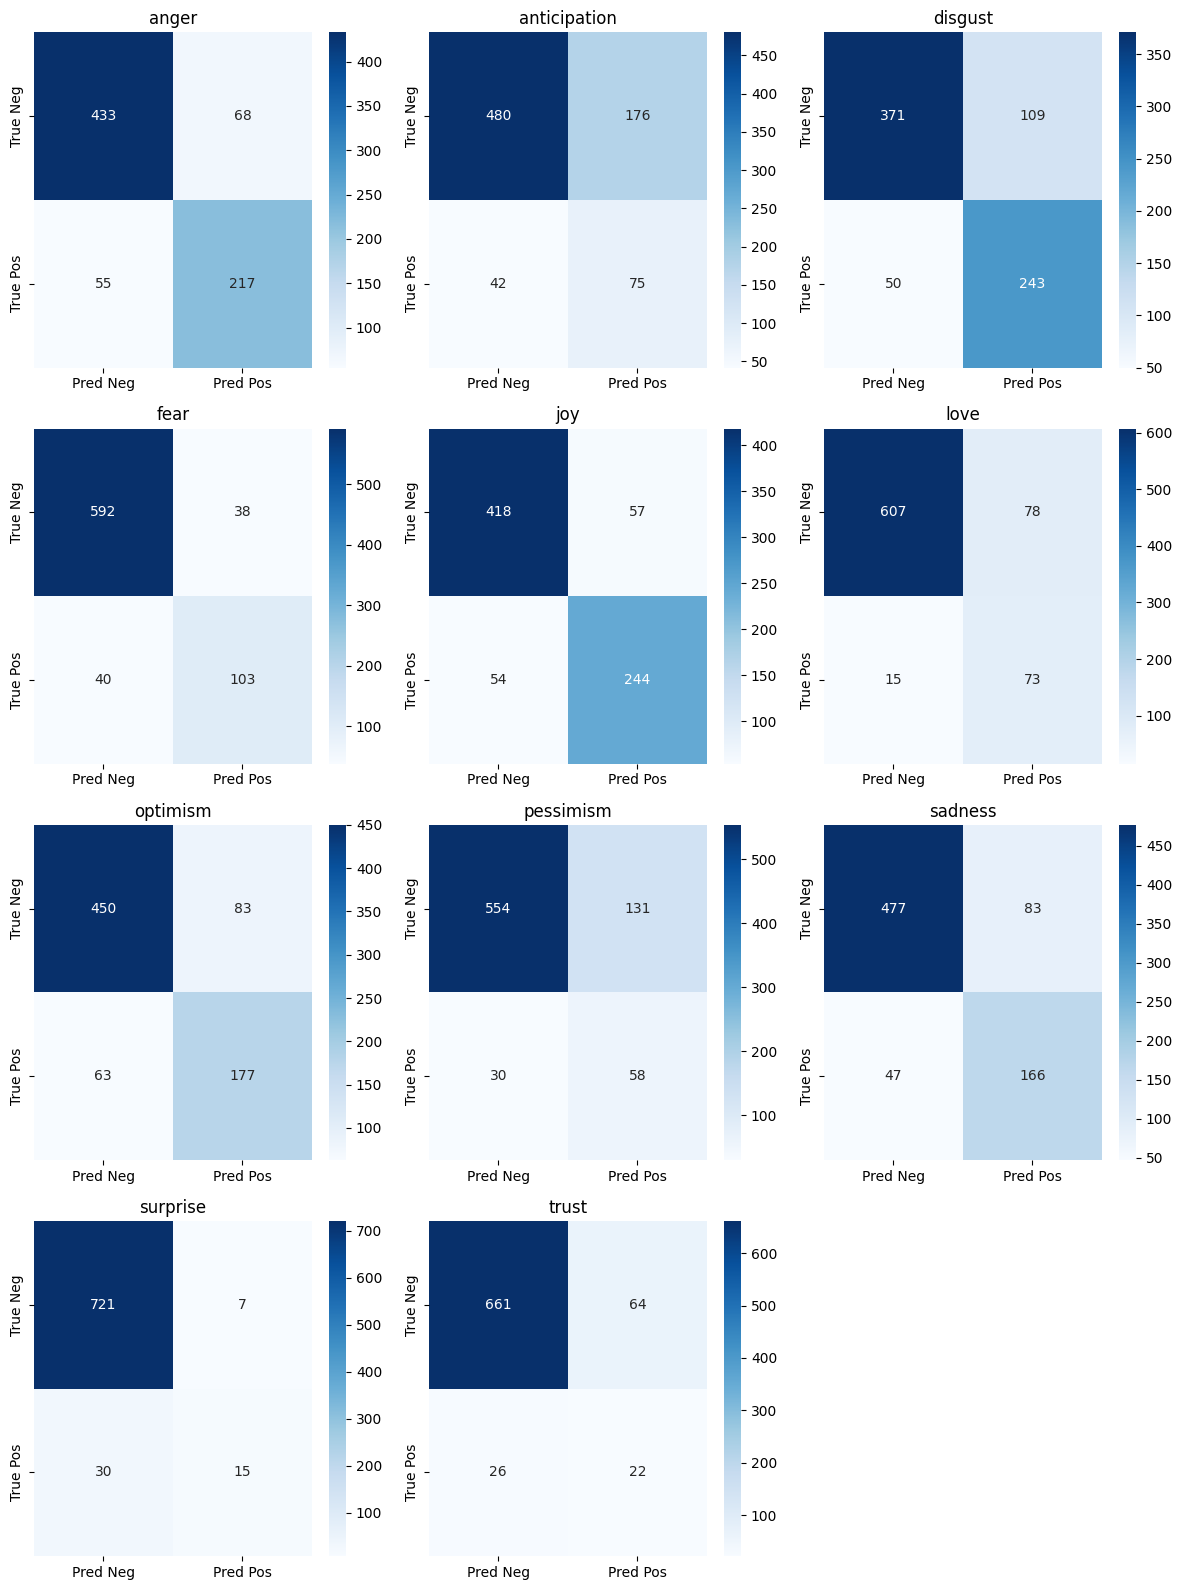

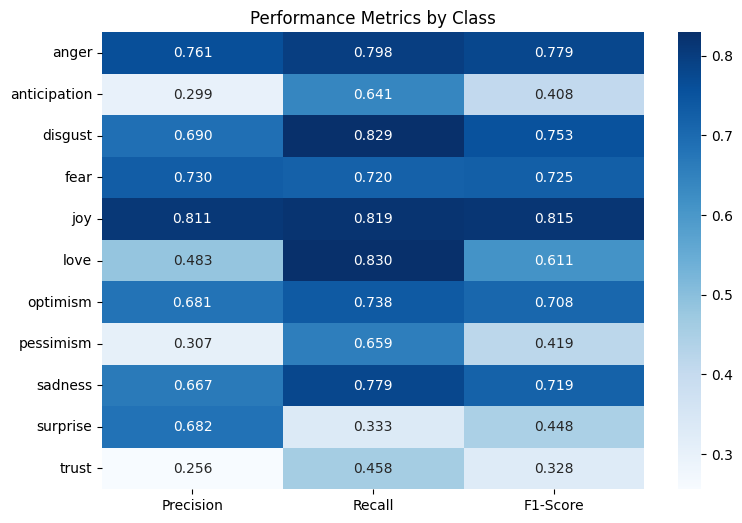

<Figure size 1200x533.333 with 0 Axes>

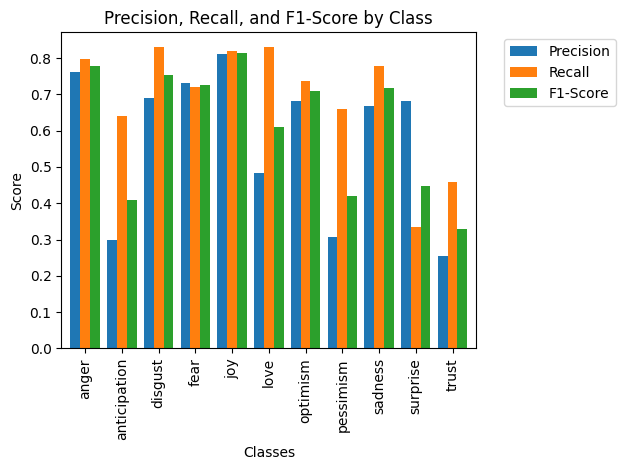

{'macro_avg': {'precision': 0.5788242663732684,
  'recall': 0.6913080649459133,
  'f1': 0.61024543867481},
 'per_class': {'Precision': {'anger': 0.7614035087719299,
   'anticipation': 0.29880478087649404,
   'disgust': 0.6903409090909091,
   'fear': 0.7304964539007093,
   'joy': 0.8106312292358804,
   'love': 0.48344370860927155,
   'optimism': 0.6807692307692308,
   'pessimism': 0.30687830687830686,
   'sadness': 0.6666666666666666,
   'surprise': 0.6818181818181818,
   'trust': 0.2558139534883721},
  'Recall': {'anger': 0.7977941176470589,
   'anticipation': 0.6410256410256411,
   'disgust': 0.8293515358361775,
   'fear': 0.7202797202797203,
   'joy': 0.8187919463087249,
   'love': 0.8295454545454546,
   'optimism': 0.7375,
   'pessimism': 0.6590909090909091,
   'sadness': 0.7793427230046949,
   'surprise': 0.3333333333333333,
   'trust': 0.4583333333333333},
  'F1-Score': {'anger': 0.7791741472172352,
   'anticipation': 0.4076086956521739,
   'disgust': 0.7534883720930232,
   'fear'

In [63]:
multilabel_evaluation(y_true=valid_labels,
                      y_pred=valid_preds,
                      class_names=class_names,
                      figsize=(12, 8))

In [64]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

# Performance on Test Set

In [65]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/llama_lora_imb/checkpoint-720'

In [66]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [67]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

# Function to tokenize text data
def tokenize_fn(batch):
    return tokenizer(text=batch["text"], truncation=True, max_length=512)

# Tokenize the unseen test data
test_set_tokenized = test_data.map(tokenize_fn, batched=True)

# Remove the 'text' column as it is not needed after tokenization
test_set_tokenized = test_set_tokenized.remove_columns(['text'])

# Set the format to PyTorch for inference
test_set_tokenized.set_format(type='torch')

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

## Training Arguments

In [71]:
training_args = TrainingArguments(
    seed = 42,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name)

## Instantiate Trainer

In [72]:
from functools import partial

In [73]:
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [74]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-74-b7cbf9c7164a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [75]:
test_results= trainer.evaluate()

In [76]:
test_results

{'eval_model_preparation_time': 0.0049,
 'eval_runtime': 14.6324,
 'eval_samples_per_second': 222.726,
 'eval_steps_per_second': 1.777}

In [77]:
wandb.log({
    "test_f1_macro": test_results.get("eval_f1_macro", None),
    "test_loss": test_results.get("eval_loss", None),
    "test_accuracy": test_results.get("eval_accuracy_all", None)
})


In [78]:
wandb.finish()

eval/accuracy_all,▁▁▁▁▂▂▂▂▁▂▂▂▃▃▅▅▅▄▆▅█▆▆▆▅▇▆▆▆▅▆██▇▆▆▇▇▇█
eval/accuracy_label,▁▁▁▂▄▅▆▆▅▆▆▆▇▆▇▇▇▇█▇███▇▇█▇██▇████▇█████
eval/f1_macro,▁▂▂▂▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇█████████▇██████████
eval/f1_micro,▁▂▂▂▄▅▆▆▅▆▆▆▆▆▇▇▇▇█▇███▇█████▇████▇█████
eval/loss,█▇▆▅▄▃▃▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▂▁▁▂▃▄▄▃▃▄▄▄▅▄▆▇▅▅▅▆▆█▇▆▇▇▆▆▆▆█▇█▇▆▆▇▇▇▃
eval/samples_per_second,▇██▇▆▅▅▆▅▅▅▅▄▅▃▂▄▄▄▃▃▁▂▃▂▂▃▃▃▃▁▂▁▂▃▃▂▂▂▆
eval/steps_per_second,▇██▇▆▅▅▆▆▅▅▅▄▅▃▂▄▄▄▃▃▁▂▃▂▂▃▃▃▃▁▁▁▂▃▃▂▂▂▆
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


# Model Inference

In [79]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
custom_pipeline = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    function_to_apply='sigmoid')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForS

## Test the pipeline on a sample Example

In [81]:
sample = valid_data['text'][0]
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.15921740233898163},
  {'label': 'anticipation', 'score': 0.917302668094635},
  {'label': 'disgust', 'score': 0.16451646387577057},
  {'label': 'fear', 'score': 0.7826625108718872},
  {'label': 'joy', 'score': 0.5746335387229919},
  {'label': 'love', 'score': 0.1127954050898552},
  {'label': 'optimism', 'score': 0.2628418207168579},
  {'label': 'pessimism', 'score': 0.2186693549156189},
  {'label': 'sadness', 'score': 0.15304215252399445},
  {'label': 'surprise', 'score': 0.5503657460212708},
  {'label': 'trust', 'score': 0.08756383508443832}]]

In [82]:
def get_positive_labels(pipeline_output, optimal_thresholds):

   positive_labels = []

   for pred_set in pipeline_output:
       # Get scores for all labels
       scores = [pred['score'] for pred in pred_set]
       labels = [pred['label'] for pred in pred_set]

       # Get positions where score > threshold for that label
       sample_positives = [
           label for label, score, threshold in zip(labels, scores, optimal_thresholds)
           if score >= threshold
       ]

       positive_labels.append(sample_positives)

   return positive_labels


In [83]:
results = get_positive_labels(preds, optimal_thresholds)
results

[['anticipation', 'fear', 'joy']]

# Model Output Logging

In [86]:
def prepare_dataset(csv_file_path, is_test=False):
    """
    Prepares a dataset for multi-label classification.

    Args:
        csv_file_path (str): Path to the CSV file.
        is_test (bool): Whether the dataset is for testing (no labels).

    Returns:
        Dataset: Hugging Face Dataset in the required format.
        list: Class names (only if not in test mode).
    """
    # Load the CSV dataset
    df = pd.read_csv(csv_file_path)

    # Define the emotion columns (labels)
    emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

    if not is_test:
        # Combine the binary emotion labels into a list for each row
        df['labels'] = df[emotion_columns].apply(
            lambda x: [emotion for emotion, value in x.items() if value == 1], axis=1
        )

        # Keep only the 'Tweet' (renamed to 'text') and 'labels' columns
        df_final = df[['Tweet', 'labels']].rename(columns={'Tweet': 'text'})

        # One-hot encode the labels using MultiLabelBinarizer
        label_encoder = MultiLabelBinarizer()
        df_final['label'] = list(label_encoder.fit_transform(df_final['labels']))

        # Define class names for reference
        class_names = label_encoder.classes_

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df_final[['text', 'label']])

        return dataset, class_names
    else:
        # For test data, keep the 'ID' and 'Tweet' columns, renaming 'Tweet' to 'text'
        df_final = df[['ID', 'Tweet']].rename(columns={'Tweet': 'text'})

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df_final[['ID', 'text']])

        return dataset


In [87]:
# Load and prepare the test dataset
test_data = prepare_dataset(csv_file_path='/content/drive/MyDrive/HW7/data_folder/test.csv', is_test=True)

# Tokenize the unseen test data
test_set_tokenized = test_data.map(tokenize_fn, batched=True)
test_set_tokenized = test_set_tokenized.remove_columns(['text'])
test_set_tokenized.set_format(type='torch')


Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [89]:
# Use `predict` to generate predictions
test_output = trainer.predict(test_set_tokenized)
test_logits = test_output.predictions

# Convert logits to probabilities using sigmoid
from scipy.special import expit as sigmoid
test_probs = sigmoid(test_logits)

# Apply optimal thresholds to obtain binary predictions
test_preds = (test_probs > optimal_thresholds).astype(int)

In [90]:
# Retrieve the IDs from the original test data
ids = test_data['ID']

# Define the class names
emotion_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                   'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Create a DataFrame with the predictions and IDs
submission_df = pd.DataFrame(test_preds, columns=emotion_columns)
submission_df['ID'] = ids  # Add the 'ID' column

# Reorder the columns to have 'ID' as the first column
submission_df = submission_df[['ID'] + emotion_columns]

# Save to CSV for Kaggle submission
submission_df.to_csv("submission_model_2.csv", index=False)